## **Importing libraries**

In [44]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import make_grid

import time
import glob

## **Importing images**

In [45]:
# Defining a transform to convert data into tensors
# * Tensors allow us to more efficiently manage the data for training NNs.
transform = transforms.ToTensor()

### **Creating placeholder arrays**

In [46]:
# There are 250 pictures per class, 150x150 pixels, total 1250 samples.
# X shape: (1250,22500) || y shape: (1250,)

# Create placeholder arrays  
X = np.zeros((1250, 150, 150))
y = np.zeros(1250)

print(X.shape, y.shape)

(1250, 150, 150) (1250,)


### **Fetch filenames**

In [47]:
# hello: 0, iloveyou: 1, no: 2, sorry: 3, yes: 4
folders = ["hello", "iloveyou", "no", "sorry", "yes"]
folder_path = "C:\\Users\\visha\\OneDrive\\Documentos\\Code\\endor\\sign_language\\Images\\test_run_images\\"
file_names = []

# Create a list with all of the images
for folder in folders:
    for f in glob.glob(folder_path + folder + '/**/*', recursive=True):
        if f[-4:] == '.jpg':
            file_names.append(f)
            
print(len(file_names))

1250


### **Save features in X array**

In [48]:
for i, file in enumerate(file_names):
    image = np.array(Image.open(file).convert('L'))
    X[i] = image

print(X.shape)

(1250, 150, 150)


In [49]:
X = X.astype(np.float32)
print(X.shape, X.dtype)

(1250, 150, 150) float32


### **Save labels in y array**

In [50]:
# Create the labels array
# hello: 0, iloveyou: 1, no: 2, sorry: 3, yes: 4
y[0:249] = 0
y[249:499] = 1
y[499:749] = 2
y[749:999] = 3
y[999:-1] = 4

y = y.astype(np.int64)
print(y.dtype)
print(np.unique(y, return_counts=True))

int64
(array([0, 1, 2, 3, 4], dtype=int64), array([250, 250, 250, 250, 250], dtype=int64))


### **Visualize samples**

Label: 0


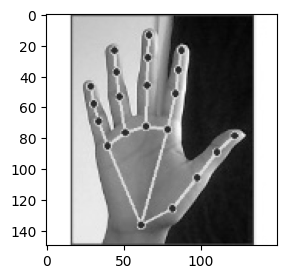

In [51]:
# Visualize a training sample
plt.figure(figsize=(3,3))
plt.imshow(X[0].reshape((150,150)), cmap="gray")
print("Label:", y[0])

Label: 1


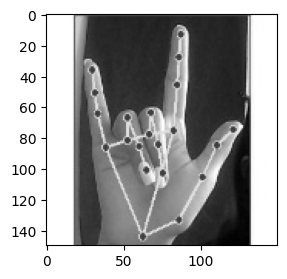

In [52]:
# Visualize a training sample
plt.figure(figsize=(3,3))
plt.imshow(X[351].reshape((150,150)), cmap="gray")
print("Label:", y[351])

## **Separating train and test data**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1000, 150, 150) (1000,)
(250, 150, 150) (250,)


## **Configuring batch loaders**

In [54]:
# Set random seed for consistency
torch.manual_seed(101)

train_data = test_data = []

for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=1000)

for i in range(len(X_test)):
   test_data.append([X_test[i], y_test[i]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=250)

## **Setting up the NN**

In [55]:
# Defining the model architecture
# * Input layer: 22500 features (150x150 pixels)
# * Output layer: 5, one per class.
# * Uses Softmax function to get class probabilities.

class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=22500, out_sz=5, layers=[4500, 900, 180, 36]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],layers[2])
        self.fc4 = nn.Linear(layers[2],layers[3])
        self.fc5 = nn.Linear(layers[3],out_sz)

    def forward(self,X):
        X = F.relu(self.fc1(X))           # ReLU as activation function.
        X = F.relu(self.fc2(X))           # ReLU as activation function.
        X = F.relu(self.fc3(X))           # ReLU as activation function.
        X = F.relu(self.fc4(X))           # ReLU as activation function.
        X = self.fc5(X)                   # Direct pass.
        return F.log_softmax(X, dim=1)    # Get class probabilities

# Use CrossEntropyLoss as loss function
criterion = nn.CrossEntropyLoss()

In [56]:
# Set seed for replicability
torch.manual_seed(101)
model = MultilayerPerceptron()

# Visualize the model architecture
model

MultilayerPerceptron(
  (fc1): Linear(in_features=22500, out_features=4500, bias=True)
  (fc2): Linear(in_features=4500, out_features=900, bias=True)
  (fc3): Linear(in_features=900, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=36, bias=True)
  (fc5): Linear(in_features=36, out_features=5, bias=True)
)

In [57]:
# Use Adam algorithm as optimizer
# * ADAM: Adaptive Moment Estimation
# * Adaptive learning rate algorithm to improve training speeds.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## **Training the model**

In [58]:
start_time = time.time()
epochs = 150

# For graphing
train_losses  = [];     test_losses  = []
train_correct = [];     test_correct = []

# For measuring accuracy
predictions_list = []
labels_list = []

for epoch in range(epochs):
    trn_correct = 0;    tst_correct = 0

    # ---- TRAINING ----
    for b, (X_train, y_train) in enumerate(train_loader):
      y_pred = model(X_train.view(X_train.size(0),-1))    # Flatten the image
      loss = criterion(y_pred, y_train)
      b += 1

      # Count correct predictions
      predicted = torch.max(y_pred.data, 1)[1]
      trn_correct += (predicted == y_train).sum()

      # Update the parameters
      optimizer.zero_grad()     # Reset and clean previous gradient measure
      loss.backward()           # Do a backward pass to measure loss
      optimizer.step()          # Update the parameters

      # Print epoch info
      if b%200 == 0: # Print every 200 samples
            print(f'Epoch: {epoch:2}  Batch: {b:4} [{100*b:6}/60000]  Loss: {loss.item():10.8f}  \
                    Accuracy: {trn_correct.item()*100/(100*b):7.3f}%')

    # Update train loss and accuracy
    train_losses.append(loss.item())
    train_correct.append(trn_correct.item())

    # ---- TESTING ----
    # We check the accuracy of the model on unseen data at every epoch.
    with torch.no_grad():
      for b, (X_test, y_test) in enumerate(test_loader):
        labels_list.append(y_test)

        # Apply the model
        y_val = model(X_test.view(X_test.size(0), -1))  # Flatten the batch

        # Count correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions_list.append(predicted)
        tst_correct += (predicted == y_test).sum()

    # Update test loss and accuracy
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

# Print how long the training/testing took
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Duration: 834 seconds


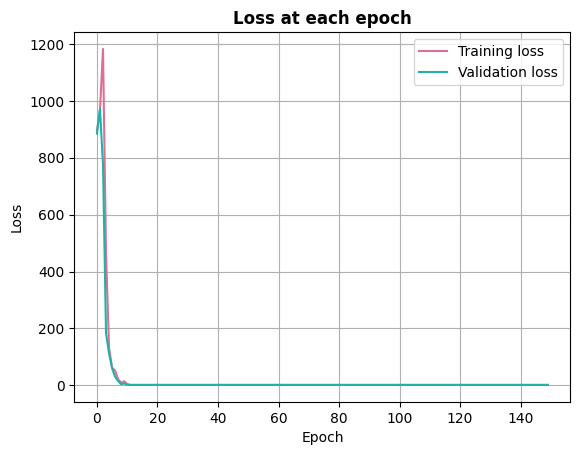

In [64]:
plt.plot(train_losses, label='Training loss', color='palevioletred')
plt.plot(test_losses, label='Validation loss', color='lightseagreen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss at each epoch', fontweight='bold')
plt.grid(visible=True)
plt.legend()

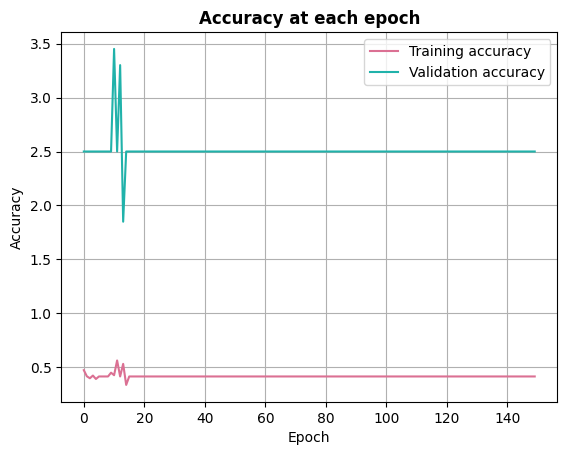

In [65]:
plt.plot([t/600 for t in train_correct], label='Training accuracy', color='palevioletred')
plt.plot([t/100 for t in test_correct], label='Validation accuracy', color='lightseagreen')
plt.title('Accuracy at each epoch', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(visible=True)
plt.legend()

## **Evaluating the model**
We now decompress the batches and test the model using the 10k test samples.

In [66]:
# Extract all samples
test_samples = DataLoader(test_data, batch_size=250, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_samples:
        y_val = model(X_test.view(X_test.size(0),-1)) 
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

# .item() returns the tensor value as a simple nummber
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):.2f}%')

Test accuracy: 250/1250 = 20.00%


In [67]:
confusion = metrics.confusion_matrix(predicted.view(-1), y_test.view(-1))
print(confusion)

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [51 61 49 46 43]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


In [68]:
# Classification report for all predictions made in training/testing

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

print("Classification report:\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.02      0.04     37500
           1       0.19      0.01      0.03     37500
           2       0.20      0.92      0.33     37500
           3       0.20      0.03      0.06     37500
           4       0.20      0.01      0.03     37500

    accuracy                           0.20    187500
   macro avg       0.20      0.20      0.10    187500
weighted avg       0.20      0.20      0.10    187500




## **Save model for inference**

In [75]:
import os
model_dir = "C:\\Users\\visha\\OneDrive\\Documentos\\Code\\endor\\sign_language\\Model"
model_path = os.path.join(model_dir, "model"+".pth")
torch.save(model.state_dict(), model_path)